# Sinusoidal model
In a first step the different blood flow models are tested with the given sinusoidal tissue architecture. The blood flow model is either 
* constant flow, i.e. identical flow in all areas of the sinusoid
* pressure dependent capillary model, i.e. different regional flow with flow component orthogonal to sinusoid direction

In [102]:
%matplotlib inline
from __future__ import print_function, division
import tellurium as te
from matplotlib import pyplot as plt
import clearance
import os
from multiscale.simulate import roadrunner_tools as rt

Time<__init__> SBML compile: 5.48030614853 [s]
['[D01__P]',
 '[D01__S]',
 '[D02__P]',
 '[D02__S]',
 '[D03__P]',
 '[D03__S]',
 '[D04__P]',
 '[D04__S]',
 '[D05__P]',
 '[D05__S]',
 '[D06__P]',
 '[D06__S]',
 '[D07__P]',
 '[D07__S]',
 '[D08__P]',
 '[D08__S]',
 '[D09__P]',
 '[D09__S]',
 '[D100__P]',
 '[D100__S]',
 '[D10__P]',
 '[D10__S]',
 '[D11__P]',
 '[D11__S]',
 '[D12__P]',
 '[D12__S]',
 '[D13__P]',
 '[D13__S]',
 '[D14__P]',
 '[D14__S]',
 '[D15__P]',
 '[D15__S]',
 '[D16__P]',
 '[D16__S]',
 '[D17__P]',
 '[D17__S]',
 '[D18__P]',
 '[D18__S]',
 '[D19__P]',
 '[D19__S]',
 '[D20__P]',
 '[D20__S]',
 '[D21__P]',
 '[D21__S]',
 '[D22__P]',
 '[D22__S]',
 '[D23__P]',
 '[D23__S]',
 '[D24__P]',
 '[D24__S]',
 '[D25__P]',
 '[D25__S]',
 '[D26__P]',
 '[D26__S]',
 '[D27__P]',
 '[D27__S]',
 '[D28__P]',
 '[D28__S]',
 '[D29__P]',
 '[D29__S]',
 '[D30__P]',
 '[D30__S]',
 '[D31__P]',
 '[D31__S]',
 '[D32__P]',
 '[D32__S]',
 '[D33__P]',
 '[D33__S]',
 '[D34__P]',
 '[D34__S]',
 '[D35__P]',
 '[D35__S]',
 '[D36__P]',
 '

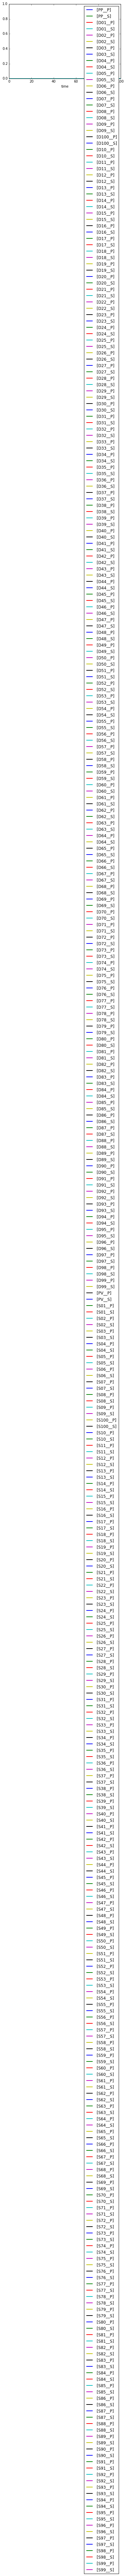

In [103]:
# flow model
# sbml_path = os.path.join(clearance.target_dir, 'sinusoidal_flow_Nc5_v3.xml')
# sbml_path = os.path.join(clearance.target_dir, 'sinusoidal_flow_Nc20_v3.xml')
sbml_path = os.path.join(clearance.target_dir, 'sinusoidal_flow_Nc100_v3.xml')

# pressure model
# sbml_path = os.path.join(clearance.target_dir, 'sinusoidal_pressure_Nc5_v3.xml')
# sbml_path = os.path.join(clearance.target_dir, 'sinusoidal_pressure_Nc20_v3.xml')

r = rt.MyRunner(sbml_path)
r.integrator.absolute_tolerance = 1E-20
r.integrator.variable_step_size = True

# print(r.getAntimony(current=False))
r.select_concentrations()
import pprint
pprint.pprint(sorted(r.timeCourseSelections))

r.resetToOrigin()
s = r.simulate(0,100)
r.plot(s);

(0, 5)

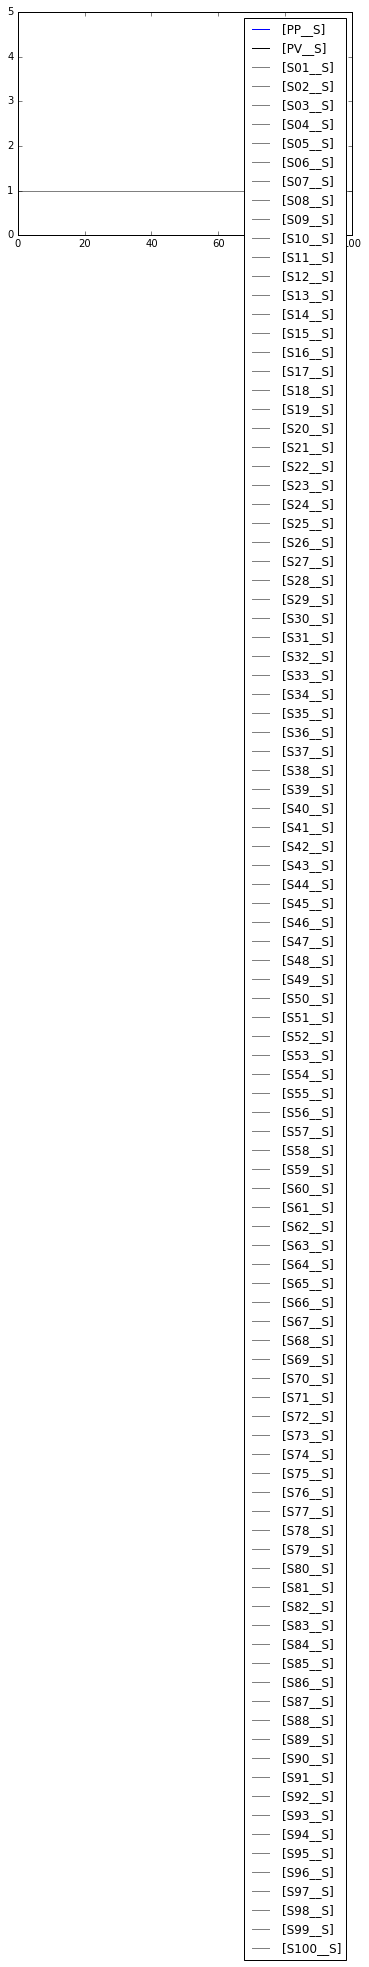

In [104]:
plt.plot(s['time'], s['[PP__S]'], color='blue', label='[PP__S]')
plt.plot(s['time'], s['[PV__S]'], color='black', label='[PV__S]')
for k in range(int(r.Nc)):
    label = '[S{:02}__S]'.format(k+1)
    plt.plot(s['time'], s[label], color='gray', label=label)
plt.legend()
plt.ylim([0,5])

## Velocity of transportation
How fast is a change in concentration transported from periportal to perivenous.

Time<simulate> : 0.238952875137 [s]


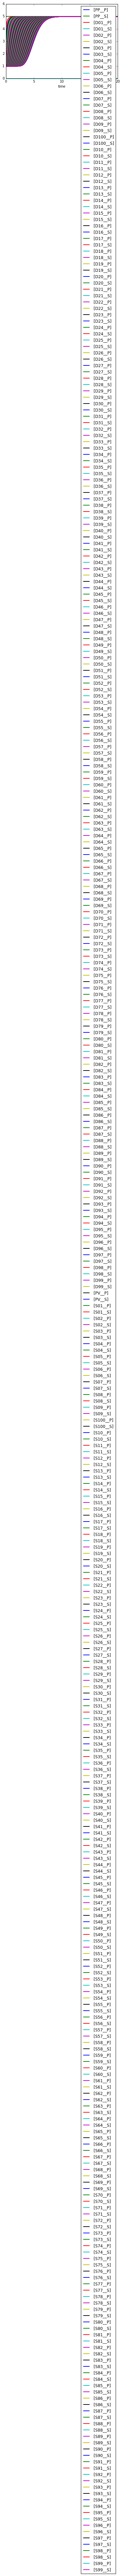

In [105]:
# perform periportal change
r.resetToOrigin()
r['[PP__S]'] = 5

s = r.simulate(0,20)
r.plot(s);

In [106]:
import numpy as np
from multiscale.analysis import id_tools
reload(id_tools)
resolver = id_tools.IdResolver(selections=r.timeCourseSelections, Nc=r['Nc'])

sin_ids = resolver.sinusoidal_ids('S')
disse_ids = resolver.disse_ids('S')
pp_id = resolver.pp_id('S')
pv_id = resolver.pv_id('S')

print(resolver.find_indices(sin_ids))
print(resolver.find_indices(disse_ids))
print(resolver.find_indices([pp_id] + sin_ids + [pv_id]))
print(r.timeCourseSelections)

[206, 208, 210, 212, 214, 216, 218, 220, 222, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 398, 400, 402, 404, 224]
[4, 6, 8, 10, 12, 14, 16, 18, 20, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 22]
[2, 206, 208, 210, 212, 214, 216, 218, 220, 222, 

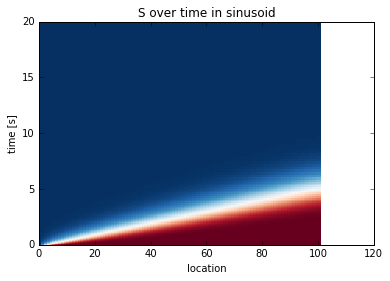

In [107]:
ids = [pp_id] + sin_ids + [pv_id]
indices = resolver.find_indices(ids)
s[:, indices]

plt.pcolor(range(0, int(r['Nc']+2)),s['time'], s[:, indices], cmap='RdBu')
plt.xlabel('location')
plt.ylabel('time [s]')
plt.title('S over time in sinusoid');

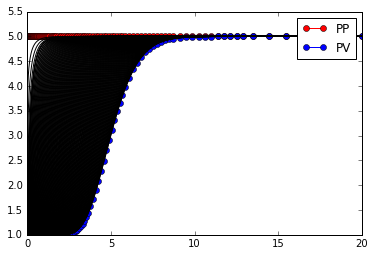

In [108]:
plt.plot(s['time'], s[pp_id], '-o', color='red', label='PP')
plt.plot(s['time'], s[pv_id], '-o', color='blue', label='PV')
plt.plot(s['time'], s[:, resolver.find_indices(sin_ids)], '-', color='black')
plt.plot(s['time'], s[:, resolver.find_indices(disse_ids)], '-', color='black')
plt.legend();

## Product formation
In the current state there is no metababolic model included.
For the transformation to P metabolic clearance is required within the cells.

['[S01__P]', '[S02__P]', '[S03__P]', '[S04__P]', '[S05__P]', '[S06__P]', '[S07__P]', '[S08__P]', '[S09__P]', '[S10__P]', '[S11__P]', '[S12__P]', '[S13__P]', '[S14__P]', '[S15__P]', '[S16__P]', '[S17__P]', '[S18__P]', '[S19__P]', '[S20__P]', '[S21__P]', '[S22__P]', '[S23__P]', '[S24__P]', '[S25__P]', '[S26__P]', '[S27__P]', '[S28__P]', '[S29__P]', '[S30__P]', '[S31__P]', '[S32__P]', '[S33__P]', '[S34__P]', '[S35__P]', '[S36__P]', '[S37__P]', '[S38__P]', '[S39__P]', '[S40__P]', '[S41__P]', '[S42__P]', '[S43__P]', '[S44__P]', '[S45__P]', '[S46__P]', '[S47__P]', '[S48__P]', '[S49__P]', '[S50__P]', '[S51__P]', '[S52__P]', '[S53__P]', '[S54__P]', '[S55__P]', '[S56__P]', '[S57__P]', '[S58__P]', '[S59__P]', '[S60__P]', '[S61__P]', '[S62__P]', '[S63__P]', '[S64__P]', '[S65__P]', '[S66__P]', '[S67__P]', '[S68__P]', '[S69__P]', '[S70__P]', '[S71__P]', '[S72__P]', '[S73__P]', '[S74__P]', '[S75__P]', '[S76__P]', '[S77__P]', '[S78__P]', '[S79__P]', '[S80__P]', '[S81__P]', '[S82__P]', '[S83__P]', '[S

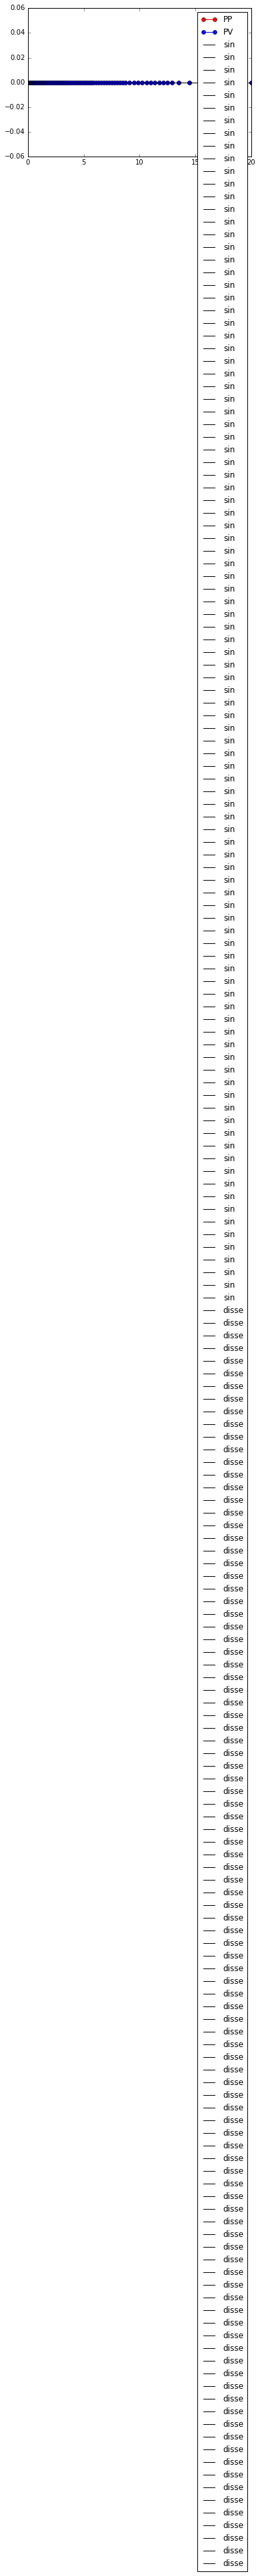

In [109]:
sin_ids_P = resolver.sinusoidal_ids('P')
disse_ids_P = resolver.disse_ids('P')
pp_id_P = resolver.pp_id('P')
pv_id_P = resolver.pv_id('P')
print(sin_ids_P)
print(disse_ids_P)
print(pp_id_P)
print(pv_id_P)


plt.plot(s['time'], s[pp_id_P], '-o', color='red', label='PP')
plt.plot(s['time'], s[pv_id_P], '-o', color='blue', label='PV')
plt.plot(s['time'], s[:, resolver.find_indices(sin_ids_P)], '-', color='black', label='sin')
plt.plot(s['time'], s[:, resolver.find_indices(disse_ids_P)], '-', color='black', label='disse')
plt.legend();

In [110]:

print(r['flow_sin'])
print(r['L'])

0.000229
0.0005
